In [16]:
import numpy as np
#import matplotlib.pyplot as plt
import scipy.io,scipy.misc
import os
import skimage.transform
import random
import cv2
from scipy import signal
# from PIL import Image
#img = Image.open('image.png').convert('LA')
#img.save('greyscale.png')
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
File_names = []
for dirpath, dirnames, filenames in os.walk("/home/qian/Downloads/high_res_img/"): #############
    for filename in filenames:
        File_names.append(os.path.join(dirpath, filename))
    
img_file_names = []

print(len(File_names))

5004


In [3]:
image_size1 = 256
image_size2 = 256
Num_of_data = 20000###########################################
#Focus_step = 200

In [4]:
DATA = np.zeros([Num_of_data,image_size1,image_size2,1],np.float32)
Label = np.zeros([Num_of_data,2],np.float32)


# In[6]:

In [5]:
Ground_truth_space = [475, 500, 525, 550, 600, 650, 675, 725, 800, 875, 1000]
Ground_truth_space = Ground_truth_space[::-1]
Data_space = Ground_truth_space
print("Data_space size:", len(Data_space))
#print Data_space

Data_space size: 11


In [6]:
def noisy(noise_typ,image):
    if noise_typ == "gauss":
        row,col= image.shape
        mean = 0
        var = 0.00
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col))
        gauss = gauss.reshape(row,col)
        noisy = image + abs(gauss)
        return noisy
    elif noise_typ == "poisson":
        image = np.maximum(image,0)
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image*255) / float(255) + image
        return noisy
    elif noise_typ =="speckle":
        row,col,ch = image.shape
        gauss = np.random.randn(row,col,ch)
        gauss = gauss.reshape(row,col,ch)        
        noisy = image + image * gauss
        return noisy
    elif noise_typ =="None":
        return image

In [7]:
def Defocus(input_image, filter_size, scale):
    input_image = np.power(input_image,2.2)
    #print filter_size
    #print 'filters/{}.mat'.format(int(filter_size))
    #print('filters/{}.mat'.format(int(filter_size)))
    a = scipy.io.loadmat('filters/{}.mat'.format(int(filter_size)))
    h = a['h']
    pip = signal.convolve(input_image, h, mode='full', method='auto');
    pip2 = skimage.transform.rescale(pip, scale)
    M = pip2.shape[0]//2
    N = pip2.shape[1]//2
    #plt.imshow(pip2)
    #plt.show()

    #idx1 = random.randint(-200,200)
    #idx2 = random.randint(-200,200)
    idx1 = 0
    idx2 = 0

   # print("M: {}, N: {}, imagesize1: {}, imagesize2: {}".format(M, N, image_size1, image_size2))
  #  print("pip2 shape: ", pip2.shape)
 #   print("scale = {}".format(scale))
    #print("a:{} b:{} c:{} d:{}".format((M-image_size1/2+idx1),(M+image_size1/2+idx1),(N-image_size2/2+idx2),(N+image_size2/2+idx2)))
    crop = np.maximum(0,pip2[(M-image_size1//2+idx1):(M+image_size1//2+idx1),(N-image_size2//2+idx2):(N+image_size2//2+idx2)])
    crop_noise = np.power(crop,1/2.2)#noisy("gauss",crop)
    #plt.imshow(crop)
    #plt.show()
    crop_noise = (crop_noise - crop_noise.min()) / (crop_noise.max()-crop_noise.min())
    return crop_noise

In [8]:
def Data_aug(im):
    k = 180
    caseidx = random.randint(1,4)
    if caseidx == 1:
        return im[im.shape[0]//2-k:im.shape[0]//2+k,im.shape[1]//2-k:im.shape[1]//2+k]
#     elif caseidx == 2:
#         return np.rot90(im)
    elif caseidx == 2:
        return np.rot90(np.rot90(im[im.shape[0]//2-k:im.shape[0]//2+k,im.shape[1]//2-k:im.shape[1]//2+k]))
#     elif caseidx == 4:
#         return np.rot90(np.rot90(np.rot90(im)))
    elif caseidx == 3:
        return np.flip(im[im.shape[0]//2-k:im.shape[0]//2+k,im.shape[1]//2-k:im.shape[1]//2+k],1)
#     elif caseidx == 6:
#         return np.rot90(np.flip(im,1))
    elif caseidx == 4:
        return np.rot90(np.rot90(np.flip(im[im.shape[0]//2-k:im.shape[0]//2+k,im.shape[1]//2-k:im.shape[1]//2+k],1)))
#     elif caseidx == 8:
#         return np.rot90(np.rot90(np.rot90(np.flip(im,1))))

In [9]:
for i in range(Num_of_data):
    print(i)
    ## Load an image and convert it to grayscale
    idx = random.randint(0,len(File_names)-1)
    img = cv2.imread(File_names[idx],0)
    img_file_names.append(File_names[idx])
    while True:
        if min(img.shape[0]-360,img.shape[1]-360) > 0:
            break
        idx = random.randint(0,len(File_names)-1)
        img = cv2.imread(File_names[idx],0)
        img_file_names[i] = File_names[idx]
    
    Focused_image = Data_aug(img)
    if Focused_image.max()>1:
        Focused_image = Focused_image/255.0
    #plt.imshow(Focused_image)
    #plt.show()
    ## Generate the statistics
    
    current_position = random.choice(Ground_truth_space)
    defocus1 = random.choice(Data_space)
    print(current_position)
    print(defocus1)
    if defocus1 == current_position:
        DATA[i,:,:,0] = Focused_image[Focused_image.shape[0]//2-image_size1//2:Focused_image.shape[0]//2+image_size1//2,Focused_image.shape[1]//2-image_size2//2:Focused_image.shape[1]//2+image_size2//2]
        DATA[i,:,:,0] = (DATA[i,:,:,0] - DATA[i,:,:,0].min())/(DATA[i,:,:,0].max() - DATA[i,:,:,0].min())
    else:
        model_mat = scipy.io.loadmat('vcm_models/Model_parameters_{}.mat'.format(current_position))  ###########################
        #print(model_mat.keys())
        Model_parameters = model_mat['Model_parameters']
#         print(s"defocus1 = {}, current pos = {}".format(defocus1, current_position))
#         print("focus img shape", Focused_image.shape)
#         print(Model_parameters[10, :])
        
        DATA[i,:,:,0] = Defocus(Focused_image,Model_parameters[Data_space.index(defocus1),2],Model_parameters[Data_space.index(defocus1),3])
    Label[i,0] = current_position
    Label[i,1] = defocus1

#     print(Label[i,:])
    

0
500
525
1
525
650
2
725
675
3


/home/qian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/home/qian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/qian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


675
475
4
875
1000
5
650
525
6
550
550
7
475
875
8
725
600
9
725
875
10
475
600
11
725
875
12
525
800
13
600
550
14
875
875
15
675
550
16
500
475
17
725
650
18
500
800
19
550
500


In [10]:
np.save('vcm_data/train_data_one_im_norm_2set_256_vcm',DATA)    ##################################
np.save('vcm_data/train_label_one_im_norm_2set_256_vcm',Label)  ##################################

'\nimport pickle\nwith open("file_names_one_im_norm_2set_512_1000_2000.txt", "wb") as fp:   #Pickling  ####################################\n    pickle.dump(img_file_names, fp)\n'

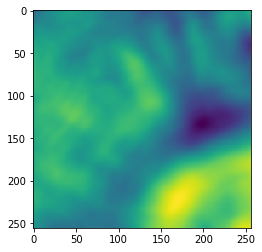

In [24]:
plt.imshow(DATA[18, :, :, 0])

In [25]:
print(Label[18, :])

[500. 800.]
